# Data sampling and Image size reshaping

## Imports

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from IPython.display import clear_output

2025-01-03 19:31:55.663599: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-03 19:31:56.177221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735929116.390176   28440 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735929116.443933   28440 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-03 19:31:56.814364: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Reading statistics

In [2]:
stats_file = "image_dimensions.csv"
#stats_file = "/kaggle/input/image-dimensions/image_dimensions.csv"
stats = pd.read_csv(stats_file)
stats.set_index("Unnamed: 0", inplace=True)
stats.index.name = None
stats

,widths,heights
count,2801.000000,2801.000000
mean,602.956444,647.924313
std,415.799480,446.639298
min,106.000000,108.000000
25%,313.000000,383.000000
50%,546.000000,590.000000
75%,800.000000,826.000000
max,7264.000000,6017.000000
median,546.000000,590.000000


## Helper functions

In [3]:
median_width = int(stats.loc["median", "widths"])
median_height = int(stats.loc["median", "heights"])

In [4]:
def build_model(width, height, data_augmentation=None):
    model = keras.Sequential()
    model.add(layers.InputLayer(shape=(width, height, 3)))

    if data_augmentation:
        model.add(data_augmentation)

    model.add(layers.Rescaling(1./255))
    model.add(layers.Conv2D(32, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(64, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(128, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(256, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(256, 3, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

model = build_model(median_width, median_height)
model.summary()


I0000 00:00:1735929131.754991   28440 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 546, 590, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 544, 588, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 272, 294, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 270, 292, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 135, 146, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 133, 144, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 66, 72, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 70, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 35, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 33, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 253440)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       253,441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,231,937 (4.70 MB)

 Trainable params: 1,231,937 (4.70 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def load_dataset(base_dir, painters, width, height, batch_size=16, interpolation="bilinear"):
    train_dataset = image_dataset_from_directory(
        f'{base_dir}/train',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    validation_dataset = image_dataset_from_directory(
        f'{base_dir}/validation',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    test_dataset = image_dataset_from_directory(
        f'{base_dir}/test',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )

    return train_dataset, validation_dataset, test_dataset


In [6]:
def print_metrics(model, test):
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test, verbose=0)

    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Precision: {test_precision}")
    print(f"Test Recall: {test_recall}")

In [7]:
class DynamicMetricsPlotCallback(Callback):
    def __init__(self):
        super().__init__()
        self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
       
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for metric in self.history.keys():
            if metric in logs:
                self.history[metric].append(logs[metric])
       
        clear_output(wait=True)
        plt.figure(figsize=(12, 4))
       
        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(self.history['loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
       
        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(self.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
       
        plt.tight_layout()
        plt.show()

## Basic data augmentation

In [8]:
data_augmentation = keras.Sequential([
    layers.RandomTranslation(0.3,0.3)
])

In [10]:
painters = ["Rubens", "Picasso"]
#dataset_dir = "/kaggle/input/schilderijen-datasets/undersampled_dataset"
dataset_dir = "undersampled_dataset"
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height)

Found 312 files belonging to 2 classes.
Found 104 files belonging to 2 classes.
Found 104 files belonging to 2 classes.


2025-01-03 18:55:38.028882: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


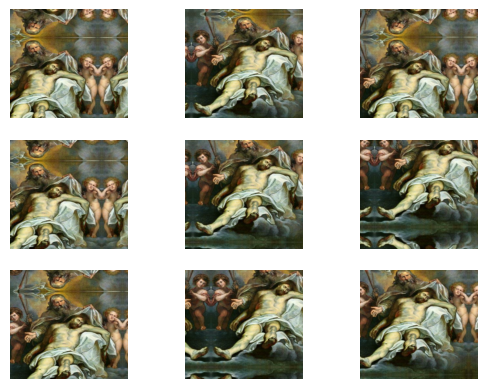

In [11]:
for images, _ in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Undersampled dataset

### Rubens en picasso

In [12]:
#dataset_dir = "/kaggle/input/schilderijen-datasets/undersampled_dataset"
dataset_dir = "undersampled_dataset"
painters = ["Rubens", "Picasso"]
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height)

Found 312 files belonging to 2 classes.
Found 104 files belonging to 2 classes.
Found 104 files belonging to 2 classes.


#### Model trainen zonder data augmentation

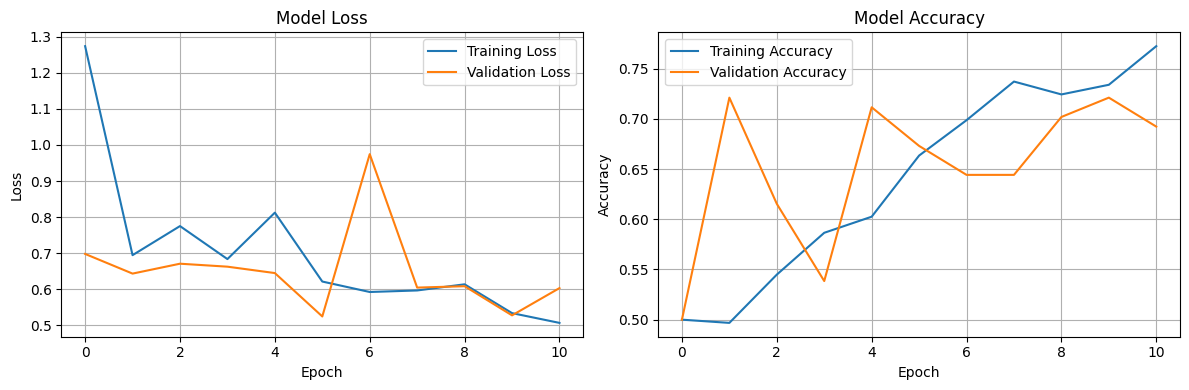

In [13]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [14]:
print_metrics(model, test)

Test Loss: 0.42804810404777527
Test Accuracy: 0.817307710647583
Test Precision: 0.8510638475418091
Test Recall: 0.7692307829856873


#### Model trainen met data augmentation

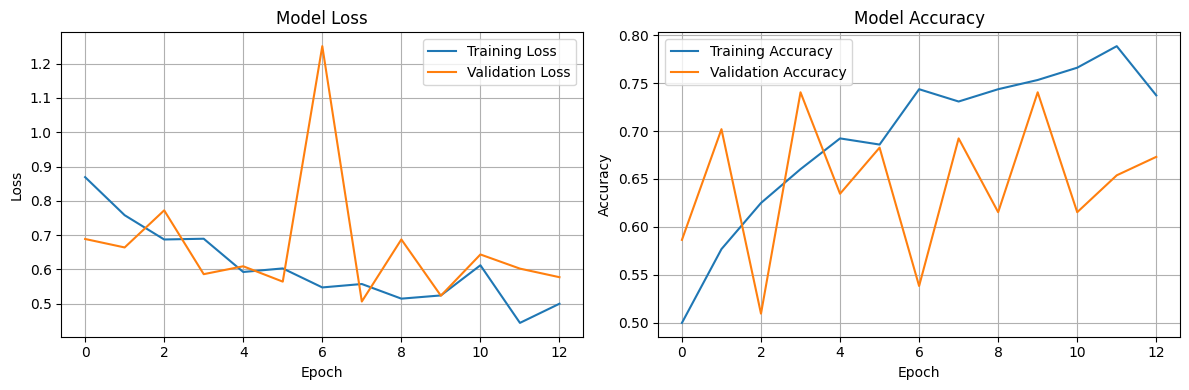

In [17]:
callbacks = [ModelCheckpoint(filepath="model_undersampled_data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [18]:
print_metrics(model, test)

Test Loss: 0.47957658767700195
Test Accuracy: 0.8269230723381042
Test Precision: 0.8695651888847351
Test Recall: 0.7692307829856873


### Mondriaan en Rubens

In [20]:
#dataset_dir = "/kaggle/input/schilderijen-datasets/undersampled_dataset"
dataset_dir = "undersampled_dataset"
painters = ["Mondriaan", "Rubens"]
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height)

Found 312 files belonging to 2 classes.
Found 104 files belonging to 2 classes.
Found 104 files belonging to 2 classes.


#### Model trainen zonder data augmentation

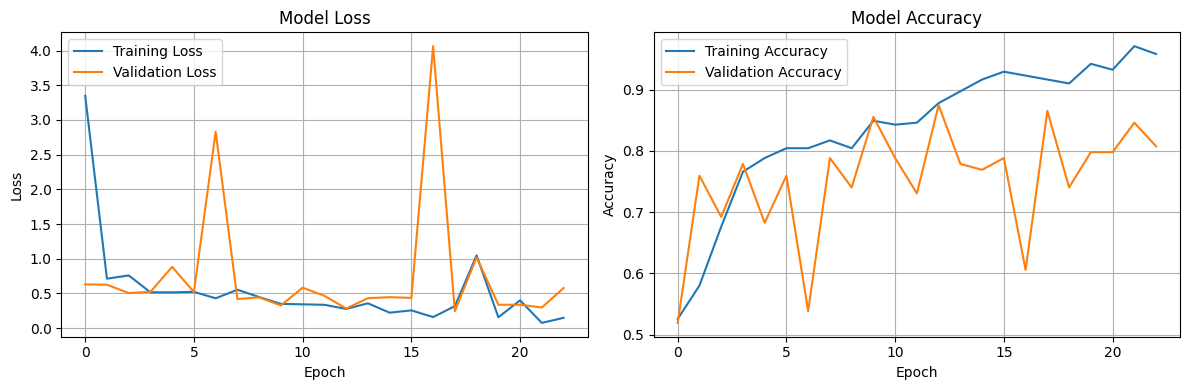

In [21]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [22]:
print_metrics(model, test)

Test Loss: 0.34216001629829407
Test Accuracy: 0.8653846383094788
Test Precision: 0.9750000238418579
Test Recall: 0.75


#### Model trainen met data augmentation

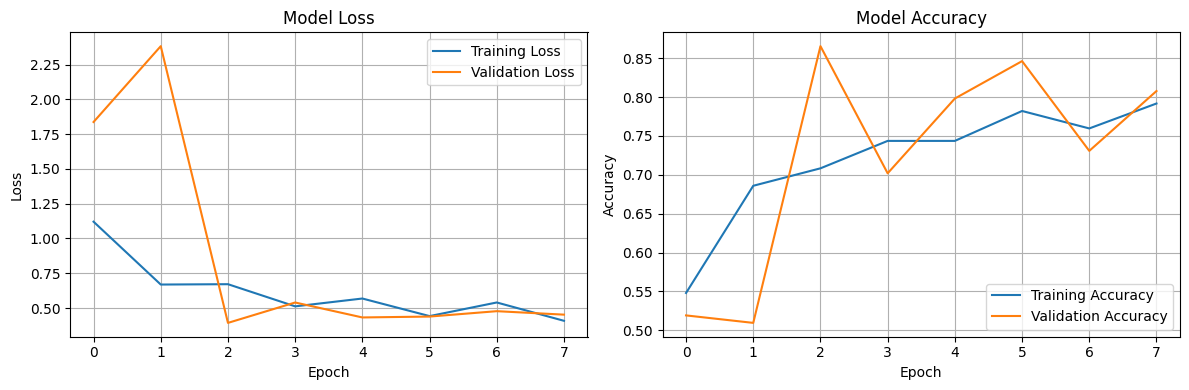

In [23]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [24]:
print_metrics(model, test)

Test Loss: 0.4175766408443451
Test Accuracy: 0.8365384340286255
Test Precision: 0.7966101765632629
Test Recall: 0.9038461446762085


## Oversampled dataset

### Rubens en picasso

In [25]:
dataset_dir = "oversampled_dataset"
#dataset_dir = "/kaggle/input/schilderijen-datasets/oversampled_dataset"
painters = ["Rubens", "Picasso"]
train, val, test = load_dataset(dataset_dir, painters, median_height, median_width, batch_size=16)

Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.


#### Model trainen zonder data augmentation

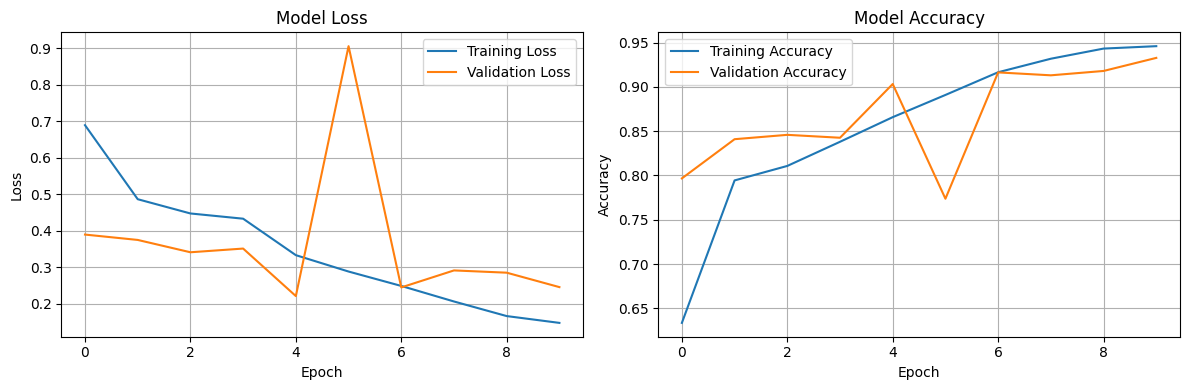

In [27]:
callbacks = [ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [28]:
print_metrics(model, test)

Test Loss: 0.30825337767601013
Test Accuracy: 0.8721311688423157
Test Precision: 0.8603174686431885
Test Recall: 0.88852459192276


#### Model trainen met data augmentation

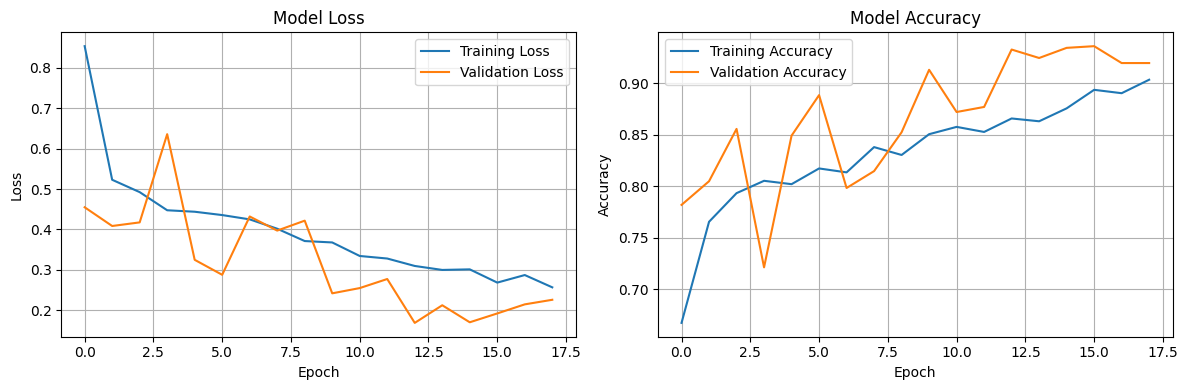

In [29]:
callbacks = [ModelCheckpoint(filepath="model_oversampled_data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [30]:
print_metrics(model, test)

Test Loss: 0.23237985372543335
Test Accuracy: 0.9032787084579468
Test Precision: 0.9100000262260437
Test Recall: 0.8950819969177246


### Mondriaan en Rembrandt

In [9]:
dataset_dir = "oversampled_dataset"
#dataset_dir = "/kaggle/input/schilderijen-datasets/oversampled_dataset"
painters = ["Mondriaan", "Rembrandt"]
train, val, test = load_dataset(dataset_dir, painters, median_height, median_width, batch_size=16)

Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.


#### Model trainen zonder data augmentation

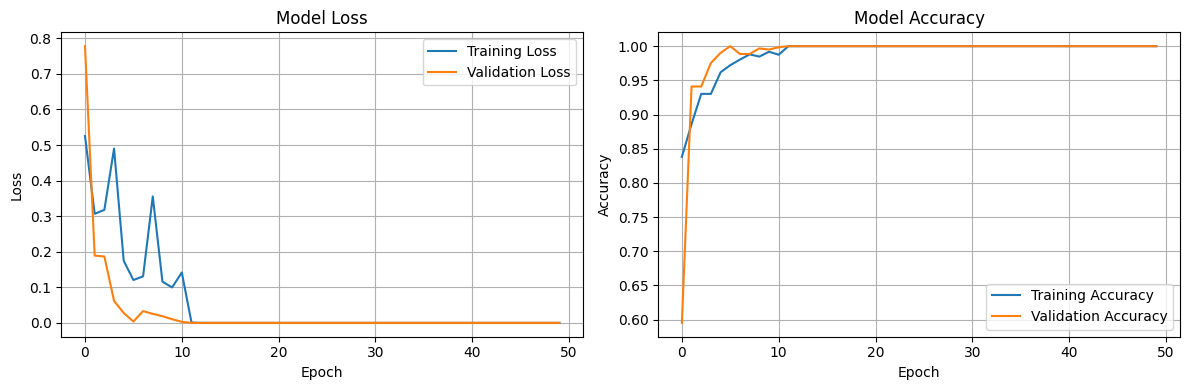

In [33]:
callbacks = [ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [34]:
print_metrics(model, test)

Test Loss: 1.6098830712962808e-08
Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0


#### Model trainen met data augmentation

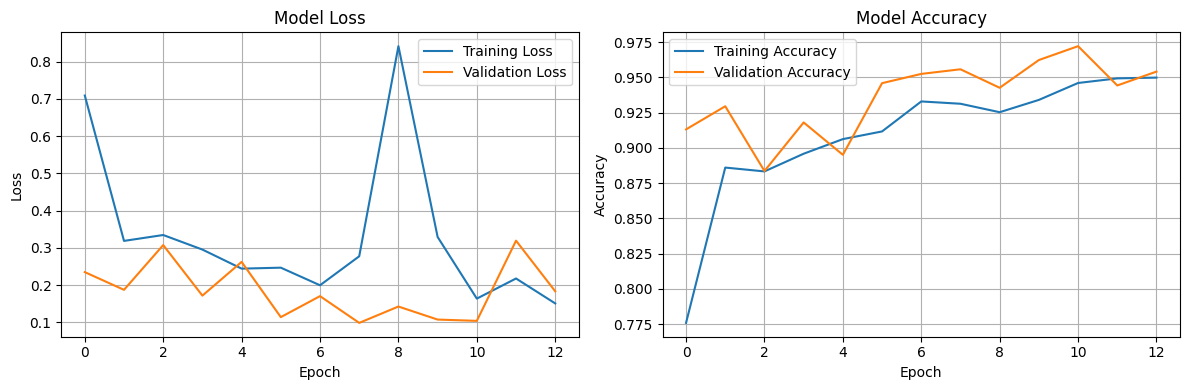

In [10]:
callbacks = [ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [11]:
print_metrics(model, test)

Test Loss: 0.08921721577644348
Test Accuracy: 0.9606557488441467
Test Precision: 1.0
Test Recall: 0.9213114976882935


## Imbalanced dataset

In [12]:
dataset_dir = "imbalanced_dataset"
#dataset_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset"
painters = ["Rubens", "Picasso"]
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height, batch_size=16)

Found 1326 files belonging to 2 classes.
Found 441 files belonging to 2 classes.
Found 444 files belonging to 2 classes.


### Rubens en picasso

#### Class weights bepalen

In [13]:
train.class_names

['Rubens', 'Picasso']

In [14]:
class_counts = {}

for _, labels in train:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

total = sum(class_counts.values())
total, class_counts

2025-01-03 19:37:23.505591: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(1326, {np.int32(1): 917, np.int32(0): 409})

In [15]:
rubens_count = class_counts.get(0, 0)  
picasso_count = class_counts.get(1, 0)   

weight_for_0 = float((1 / rubens_count) * (total / 2.0)) if rubens_count > 0 else 0
weight_for_1 = float((1 / picasso_count) * (total / 2.0)) if picasso_count > 0 else 0
class_weight = {0: weight_for_0, 1: weight_for_1}

class_weight

{0: 1.6210268948655258, 1: 0.7230098146128681}

#### Baseline

In [16]:
picasso_count / total

0.691553544494721

#### Model trainen zonder data augmentation

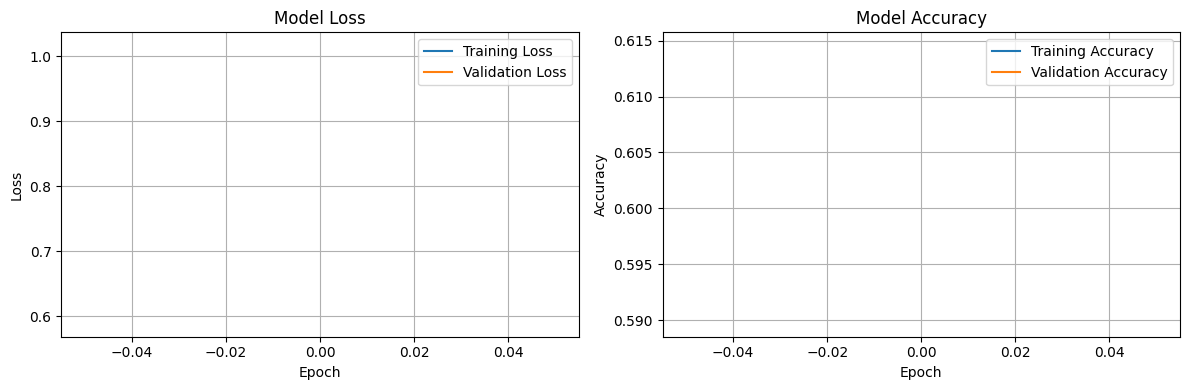

2025-01-03 19:38:35.332010: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-01-03 19:38:35.332496: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109184 bytes after encountering the first element of size 67109184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


KeyboardInterrupt: 

In [17]:
callbacks = [ModelCheckpoint(filepath="model_imbalanced.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step
Accuracy:  0.5636363636363636
Recall:  0.7081967213114754
Precision:  0.677115987460815
F1:  0.6923076923076922


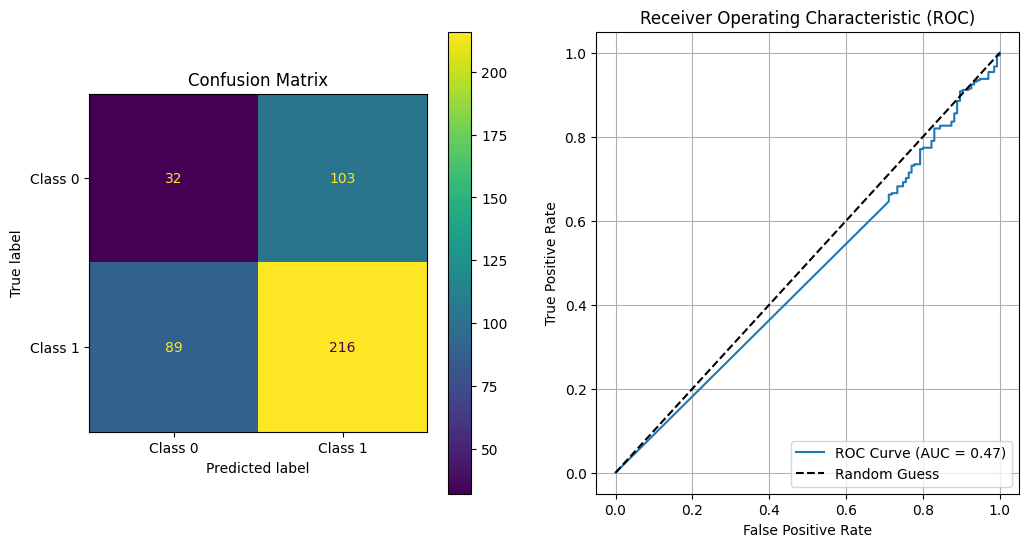

In [18]:
print_metrics(model, test)

#### Model trainen met data augmentation

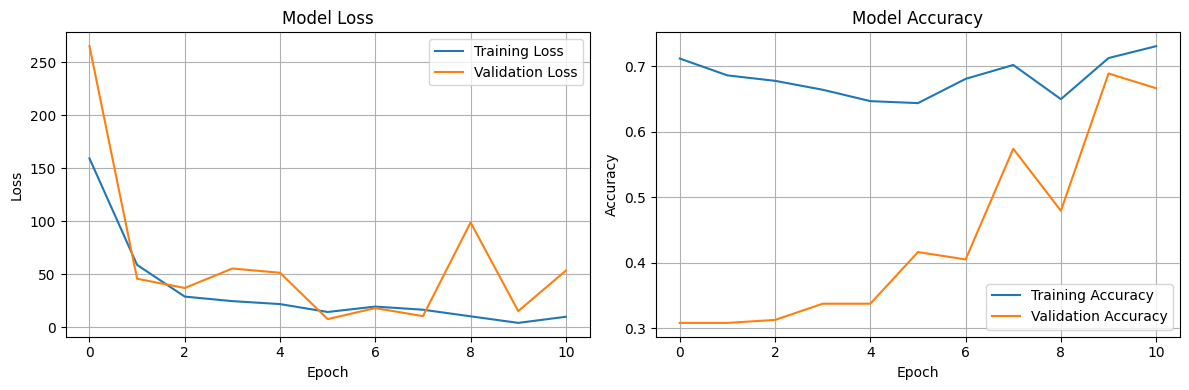

In [19]:
callbacks = [ModelCheckpoint(filepath="model_imbalanced_data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
Accuracy:  0.3704545454545455
Recall:  0.14098360655737704
Precision:  0.7413793103448276
F1:  0.2369146005509642


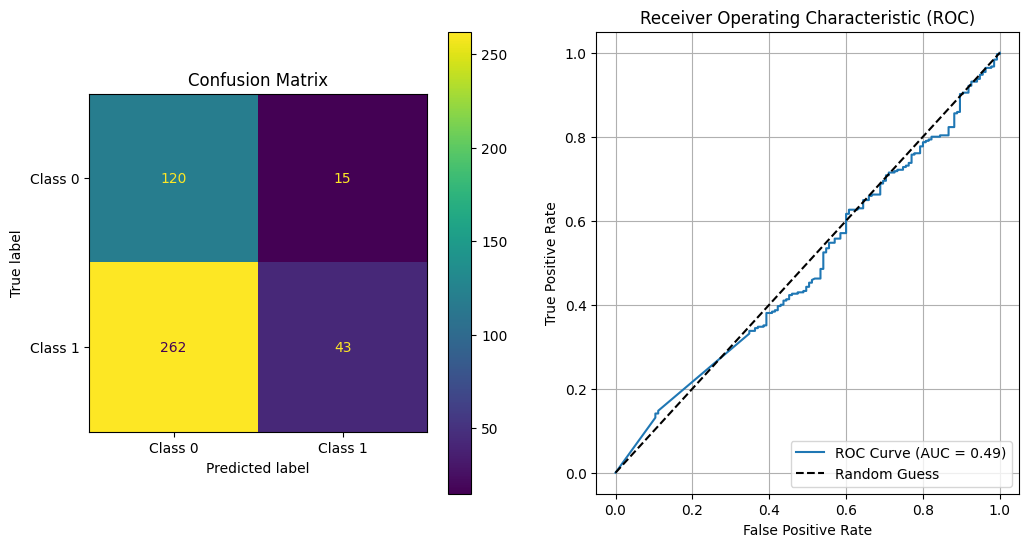

In [20]:
print_metrics(model, test)

### Mondriaan en Rembrandt

#### Data inladen

In [21]:
painters = ["Mondriaan", "Rembrandt"]
dataset_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset"
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height, batch_size=16)

Found 354 files belonging to 2 classes.
Found 118 files belonging to 2 classes.
Found 118 files belonging to 2 classes.


#### Class weights bepalen

In [22]:
class_counts = {}

for _, labels in train:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

total = sum(class_counts.values())
total, class_counts

(354, {0: 198, 1: 156})

In [23]:
mondriaan_count = class_counts.get(0, 0)  
rembrandt_count = class_counts.get(1, 0)   

weight_for_0 = float((1 / mondriaan_count) * (total / 2.0)) if mondriaan_count > 0 else 0
weight_for_1 = float((1 / rembrandt_count) * (total / 2.0)) if rembrandt_count > 0 else 0
class_weight = {0: weight_for_0, 1: weight_for_1}

class_weight

{0: 0.893939393939394, 1: 1.1346153846153846}

#### Baseline

In [24]:
mondriaan_count / total

0.559322033898305

#### Model trainen zonder data augmentatie

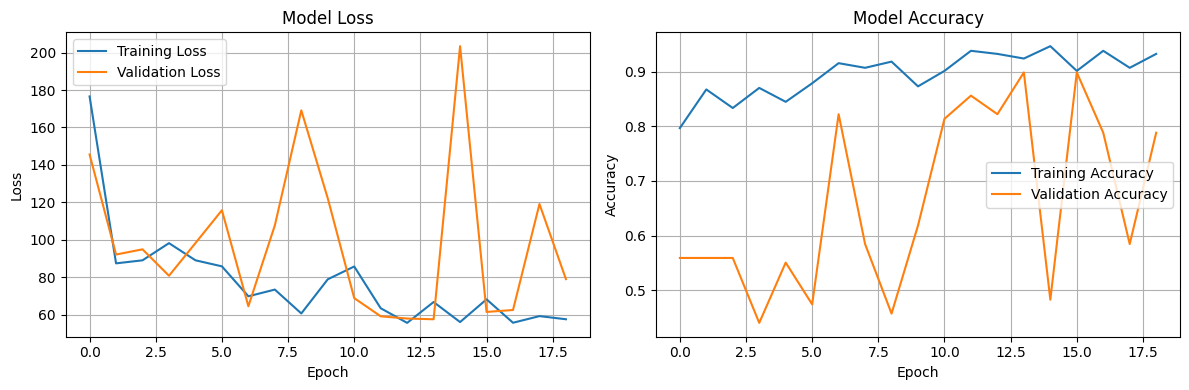

In [25]:
callbacks = [ModelCheckpoint(filepath="model_imbalanced.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Accuracy:  0.5338983050847458
Recall:  0.4807692307692308
Precision:  0.4716981132075472
F1:  0.4761904761904762


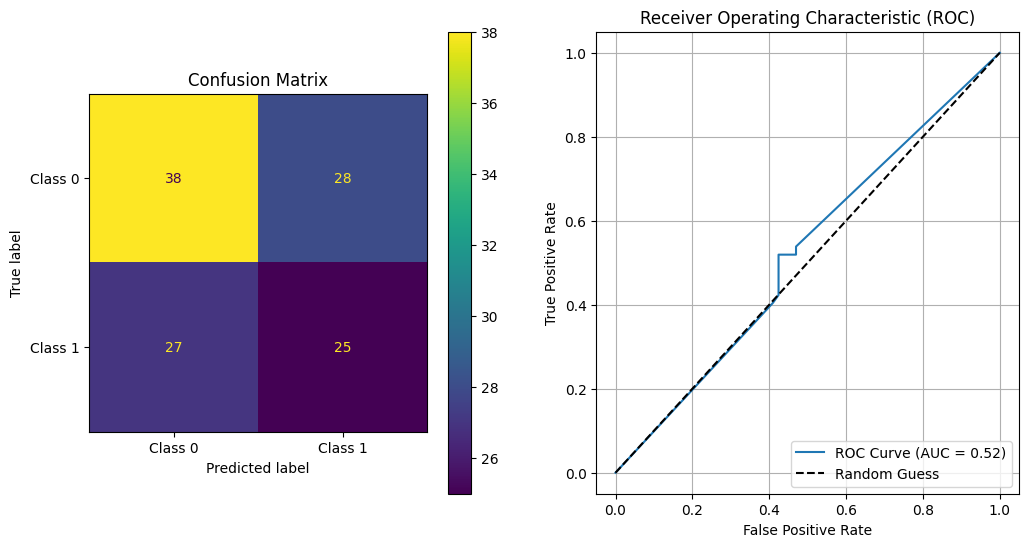

In [26]:
print_metrics(model, test)

#### Model trainen met data augmentatie

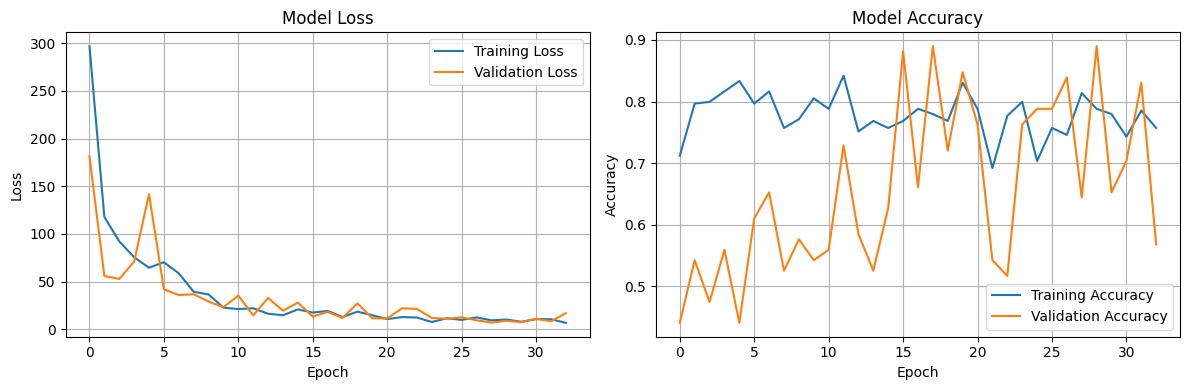

In [29]:
callbacks = [ModelCheckpoint(filepath="model_imbalanced_data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Accuracy:  0.5169491525423728
Recall:  0.9038461538461539
Precision:  0.47474747474747475
F1:  0.6225165562913907


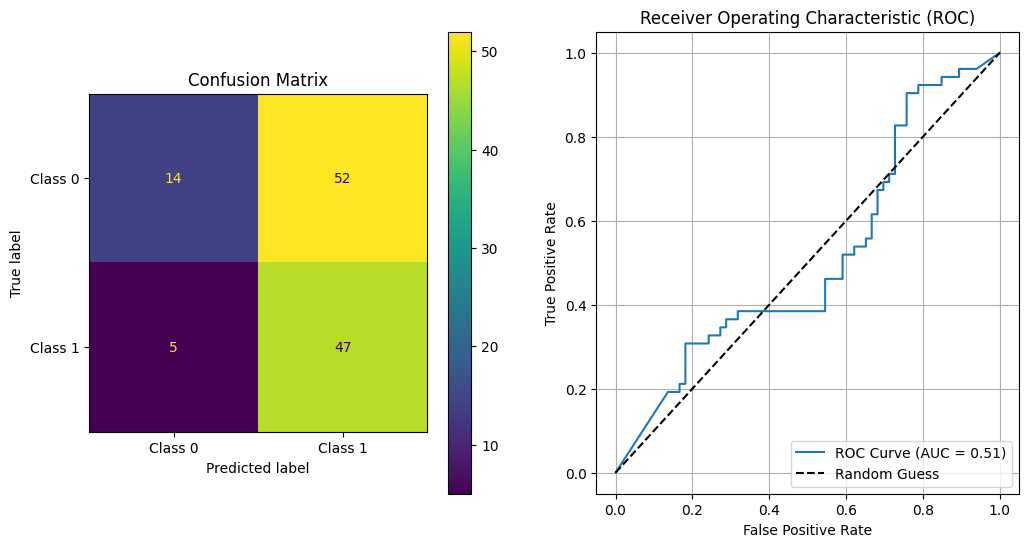

In [30]:
print_metrics(model, test)

## Image size bepalen

Grid search opsplitsen wegen RAM issues

In [6]:
def run_grid_search(statistic, dataset_dir, painters, interpolations):
    results = []

    width = int(stats.loc[f"{statistic}", "widths"])
    height = int(stats.loc[f"{statistic}", "heights"])
    
    for interpolation in interpolations:
        print(f"Processing {statistic} with interpolation: {interpolation}")

        train, val, test = load_dataset(dataset_dir, painters, width, height, batch_size=16, interpolation=interpolation)

        model = build_model(width, height)
        model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])

        callbacks = [
            keras.callbacks.ModelCheckpoint(filepath="gridsearch_model.keras", save_best_only=True, monitor="val_loss"),
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        ]
        
        history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

        test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test, verbose=0)

        results.append({
            "statistic": statistic,
            "interpolation": interpolation,
            "width": width,
            "height": height,
            "epochs": len(history.history['accuracy']),
            "train_accuracy": history.history['accuracy'][-1],
            "val_accuracy": history.history['val_accuracy'][-1],
            "test_accuracy": test_accuracy,
            "train_loss": history.history['loss'][-1],
            "val_loss": history.history['val_loss'][-1],
            "test_loss": test_loss,
            "precision": test_precision,
            "recall": test_recall
        })

        print(results[-1]) 

    df = pd.DataFrame(results)
    return df


In [7]:
interpolations = ["bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5", "gaussian"]
dataset_dir = "/kaggle/input/schilderijen-datasets/smaller_oversampled_dataset"
painters = ["Mondriaan", "Picasso"]

results_min = run_grid_search("min", dataset_dir, painters, interpolations)
results_min.to_csv("image_size_gridsearch_result_min.csv")
results_25 = run_grid_search("25%", dataset_dir, painters, interpolations)
results_25.to_csv("image_size_gridsearch_result_25.csv")

Processing min with interpolation: bilinear
Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
{'statistic': 'min', 'interpolation': 'bilinear', 'width': 106, 'height': 108, 'epochs': 34, 'train_accuracy': 0.9375, 'val_accuracy': 0.762499988079071, 'test_accuracy': 0.4875, 'train_loss': 0.718815267086029, 'val_loss': 1.0302863121032715, 'precision': 0.48704663212435234, 'recall': 0.47, 'f1_score': 0.47837150127226463, 'auc': 0.47509999999999997}
Processing min with interpolation: nearest
Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
{'statistic': 'min', 'interpolation': 'nearest', 'width': 106, 'height': 108, 'epochs': 31, 'train_accuracy': 0.9383333325386047, 'val_accuracy': 0.9024999737739563, 'test_accuracy': 0.5225, 'train_loss': 0.7222719192504883, 'val_loss':

In [8]:
interpolations = ["bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5"]
dataset_dir = "/kaggle/input/schilderijen-datasets/smaller_oversampled_dataset"
painters = ["Mondriaan", "Picasso"]

results_mean = run_grid_search("mean", dataset_dir, painters, interpolations)
results_mean.to_csv("image_size_gridsearch_result_mean.csv")

Processing mean with interpolation: bilinear
Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
{'statistic': 'mean', 'interpolation': 'bilinear', 'width': 603, 'height': 648, 'epochs': 28, 'train_accuracy': 0.7549999952316284, 'val_accuracy': 0.7950000166893005, 'test_accuracy': 0.5075, 'train_loss': 1.1100291013717651, 'val_loss': 1.008041501045227, 'precision': 0.5082872928176796, 'recall': 0.46, 'f1_score': 0.4829396325459318, 'auc': 0.5174}
Processing mean with interpolation: nearest
Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
{'statistic': 'mean', 'interpolation': 'nearest', 'width': 603, 'height': 648, 'epochs': 32, 'train_accuracy': 0.8199999928474426, 'val_accuracy': 0.7475000023841858, 'test_accuracy': 0.5025, 'train_loss': 1.1474812030792236, 'val_loss

In [8]:
interpolations = ["bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5"]
dataset_dir = "/kaggle/input/schilderijen-datasets/smaller_oversampled_dataset"
painters = ["Mondriaan", "Picasso"]
results_median = run_grid_search("median", dataset_dir, painters, interpolations)
results_median.to_csv("image_size_gridsearch_result_median.csv")

Processing median with interpolation: bilinear
Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
{'statistic': 'median', 'interpolation': 'bilinear', 'width': 550, 'height': 590, 'epochs': 11, 'train_accuracy': 0.6150000095367432, 'val_accuracy': 0.6625000238418579, 'test_accuracy': 0.515, 'train_loss': 5.741096019744873, 'val_loss': 14.8850679397583, 'precision': 0.5428571428571428, 'recall': 0.19, 'f1_score': 0.28148148148148144, 'auc': 0.49635000000000007}
Processing median with interpolation: nearest
Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
{'statistic': 'median', 'interpolation': 'nearest', 'width': 550, 'height': 590, 'epochs': 10, 'train_accuracy': 0.8633333444595337, 'val_accuracy': 0.7475000023841858, 'test_accuracy': 0.5375, 'train_loss': 33.6545524

In [7]:
interpolations = ["bilinear", "nearest"]
dataset_dir = "/kaggle/input/schilderijen-datasets/smaller_oversampled_dataset"
painters = ["Mondriaan", "Picasso"]
results_75 = run_grid_search("75%", dataset_dir, painters, interpolations)
results_75.to_csv("image_size_gridsearch_result_75.csv")

Processing 75% with interpolation: bilinear
Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
{'statistic': '75%', 'interpolation': 'bilinear', 'width': 800, 'height': 826, 'epochs': 41, 'train_accuracy': 0.7749999761581421, 'val_accuracy': 0.6825000047683716, 'test_accuracy': 0.5, 'train_loss': 1.1551417112350464, 'val_loss': 1.202347993850708, 'precision': 0.5, 'recall': 0.59, 'f1_score': 0.5412844036697249, 'auc': 0.4820875}
Processing 75% with interpolation: nearest
Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
{'statistic': '75%', 'interpolation': 'nearest', 'width': 800, 'height': 826, 'epochs': 25, 'train_accuracy': 0.7074999809265137, 'val_accuracy': 0.8075000047683716, 'test_accuracy': 0.4725, 'train_loss': 1.2818949222564697, 'val_loss': 1.22024309635162

In [7]:
gridsearch_dir = "/kaggle/input/image-size-gridsearch-result"
prefix = "image_size_gridsearch_result"
df_min = pd.read_csv(f"{gridsearch_dir}/{prefix}_min.csv")
df_25 = pd.read_csv(f"{gridsearch_dir}/{prefix}_25.csv")
df_mean = pd.read_csv(f"{gridsearch_dir}/{prefix}_mean.csv")
df_median = pd.read_csv(f"{gridsearch_dir}/{prefix}_median.csv")
df_75 = pd.read_csv(f"{gridsearch_dir}/{prefix}_75.csv")
dataframes = [df_min, df_25, df_mean, df_median, df_75]
df = pd.concat(dataframes)
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,statistic,interpolation,width,height,epochs,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
0,min,bilinear,106,108,34,0.937500,0.7625,0.4875,0.718815,1.030286,0.487047,0.470,0.478372,0.475100
1,min,nearest,106,108,31,0.938333,0.9025,0.5225,0.722272,0.805410,0.524064,0.490,0.506460,0.530763
2,min,bicubic,106,108,22,0.936667,0.8750,0.4925,0.925480,1.058127,0.492063,0.465,0.478149,0.483150
3,min,area,106,108,25,0.936667,0.8225,0.5400,0.878332,1.088206,0.543011,0.505,0.523316,0.538538
4,min,lanczos3,106,108,25,0.930000,0.8650,0.4850,0.797939,0.913272,0.485294,0.495,0.490099,0.467388


In [8]:
df.sort_values("test_accuracy", ascending=False).head(5)

,statistic,interpolation,width,height,epochs,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
4,mean,lanczos3,603,648,25,0.825000,0.7100,0.5400,1.654476,1.935966,0.552632,0.420,0.477273,0.530688
3,min,area,106,108,25,0.936667,0.8225,0.5400,0.878332,1.088206,0.543011,0.505,0.523316,0.538538
1,median,nearest,550,590,10,0.863333,0.7475,0.5375,33.654552,45.646187,0.525773,0.765,0.623218,0.538050
2,25%,bicubic,314,383,8,0.705000,0.6900,0.5275,6.289367,9.830175,0.603774,0.160,0.252964,0.563500
1,min,nearest,106,108,31,0.938333,0.9025,0.5225,0.722272,0.805410,0.524064,0.490,0.506460,0.530763


In [10]:
df.sort_values("precision", ascending=False).head(5)

,statistic,interpolation,width,height,epochs,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
5,25%,lanczos5,314,383,7,0.659167,0.5025,0.5100,2.253230,64.901855,0.750000,0.030,0.057692,0.499913
2,25%,bicubic,314,383,8,0.705000,0.6900,0.5275,6.289367,9.830175,0.603774,0.160,0.252964,0.563500
4,mean,lanczos3,603,648,25,0.825000,0.7100,0.5400,1.654476,1.935966,0.552632,0.420,0.477273,0.530688
3,min,area,106,108,25,0.936667,0.8225,0.5400,0.878332,1.088206,0.543011,0.505,0.523316,0.538538
0,median,bilinear,550,590,11,0.615000,0.6625,0.5150,5.741096,14.885068,0.542857,0.190,0.281481,0.496350


In [11]:
df.sort_values("recall", ascending=False).head(5)

,statistic,interpolation,width,height,epochs,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
4,25%,lanczos3,314,383,10,0.796667,0.5400,0.5200,2.521586,29.076406,0.510929,0.935,0.660777,0.468500
4,median,lanczos3,550,590,8,0.593333,0.6500,0.4950,5.784430,12.886982,0.497041,0.840,0.624535,0.511350
1,median,nearest,550,590,10,0.863333,0.7475,0.5375,33.654552,45.646187,0.525773,0.765,0.623218,0.538050
0,75%,bilinear,800,826,41,0.775000,0.6825,0.5000,1.155142,1.202348,0.500000,0.590,0.541284,0.482088
3,25%,area,314,383,36,0.923333,0.9000,0.4925,1.115873,1.211595,0.493450,0.565,0.526807,0.482600


In [12]:
df.sort_values("val_loss").head(5)

,statistic,interpolation,width,height,epochs,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
3,mean,area,603,648,35,0.591667,0.6525,0.4825,0.759442,0.743329,0.476190,0.350,0.403458,0.478687
1,min,nearest,106,108,31,0.938333,0.9025,0.5225,0.722272,0.805410,0.524064,0.490,0.506460,0.530763
4,min,lanczos3,106,108,25,0.930000,0.8650,0.4850,0.797939,0.913272,0.485294,0.495,0.490099,0.467388
0,mean,bilinear,603,648,28,0.755000,0.7950,0.5075,1.110029,1.008042,0.508287,0.460,0.482940,0.517400
0,min,bilinear,106,108,34,0.937500,0.7625,0.4875,0.718815,1.030286,0.487047,0.470,0.478372,0.475100


In [17]:
df.to_csv("image_size_gridsearch_result.csv")